In [1]:
# DEPENDENCIES
import glob, math, json, glob, re
#from shutil import copyfile
import numpy as np
import pandas as pd
#import logomaker
# LOCAL IMPORTS
#from indexing_classes import GPCRDBIndexing
from gain_classes import GainDomain, GainCollection, Anchors, GPS
import sse_func
import matplotlib.pyplot as plt
import template_finder as tf

def calc_identity(aln_matrix):
    # This takes an alignment matrix with shape=(n_columns, n_sequences) and generates counts based on the identity matrix.
    # Returns the highest non "-" residue count as the most conserved residue and its occupancy based on count("-") - n_struc
    n_struc = aln_matrix.shape[0]
    quality = []
    occ = []
    for col in range(aln_matrix.shape[1]):
        chars, count = np.unique(aln_matrix[:,col], return_counts=True)
        dtype = [('aa', 'S1'), ('counts', int)]
        values = np.array(list(zip(chars,count)), dtype=dtype)
        s_values = np.sort(values, order='counts')

        if s_values[-1][0] == b'-':
            q = s_values[-2][1]
        else:
            q = s_values[-1][1]
        x = np.where(chars == '-')[0][0]
        occ.append(n_struc - count[x])
        quality.append(q)
    return quality, occ


Initialize pre-calculated metrix for the collection.

In [2]:
valid_seqs = sse_func.read_multi_seq("/home/hildilab/projects/agpcr_nom/app_gain_gain.fa")
quality_file = "/home/hildilab/projects/agpcr_nom/app_gain_gain.mafft.jal"
alignment_file = "/home/hildilab/projects/agpcr_nom/app_gain_gain.mafft.fa"
stride_files = glob.glob("/home/hildilab/projects/agpcr_nom/sigmas/sigma_2/*")
# This only contains the sigma files for truncated (?) PDBs.
#quality = sse_func.read_quality(quality_file)
gps_minus_one = 6781 
aln_cutoff = 6826 
alignment_dict = sse_func.read_alignment(alignment_file, aln_cutoff)
aln_matrix = np.array([list(seq) for seq in alignment_dict.values()])
#print(aln_matrix.shape)
quality, occ = calc_identity(aln_matrix)

"""precalc_anchors = [ 662, 1194, 1912, 2490, 2848, 3011, 3073, 3260, #H1-H8
            3455, 3607, 3998, 4279, 4850, 5339, #5341 S1-S6, S7 REMOVED!
            5413, 5813, 6337, 6659, 6696, 6765, 6808] #S8-13
precalc_anchor_occupation = [ 4594.,  6539., 11392., 13658.,  8862., 5092.,  3228., 14189., #H1-H8
                      9413., 12760.,  9420., 11201., 12283., 3676.,#  4562. S1-S6, S7 REMOVED!
                     13992., 12575., 13999., 14051., 14353., 9760., 14215.] #S8-13
precalc_anchor_dict = sse_func.make_anchor_dict(precalc_anchors, 3425)"""


'precalc_anchors = [ 662, 1194, 1912, 2490, 2848, 3011, 3073, 3260, #H1-H8\n            3455, 3607, 3998, 4279, 4850, 5339, #5341 S1-S6, S7 REMOVED!\n            5413, 5813, 6337, 6659, 6696, 6765, 6808] #S8-13\nprecalc_anchor_occupation = [ 4594.,  6539., 11392., 13658.,  8862., 5092.,  3228., 14189., #H1-H8\n                      9413., 12760.,  9420., 11201., 12283., 3676.,#  4562. S1-S6, S7 REMOVED!\n                     13992., 12575., 13999., 14051., 14353., 9760., 14215.] #S8-13\nprecalc_anchor_dict = sse_func.make_anchor_dict(precalc_anchors, 3425)'

In [3]:
# In addition to the collection, we need the corresponding PDB files.
valid_collection = pd.read_pickle("../valid_collection.pkl")
allpdbs = glob.glob('../all_pdbs/*.pdb')

In [4]:
# Get the Data for the initially selected templates
def get_template_information(identifier, gain_collection, subdomain='a', threshold=3, no_input=True):
    for gain in gain_collection.collection:
        if identifier in gain.name:
            print(gain.name, gain.start, gain.subdomain_boundary, gain.end, "\n")

            if subdomain.lower() == 'a':
                sse = gain.sda_helices
                d_string = "HELIX "
                sse_type = "H"
            elif subdomain.lower() == 'b':
                sse = gain.sdb_sheets
                d_string = "STRAND"
                sse_type = "S"
            else:
                print("NO SUBDOMAIN specified. EXITING.")
        
            #print(sse)
            anchor_quality = {}
            anchors = {}
            counter = 1
            aln_indices = []
            for i,element in enumerate(sse):
                if element[1]-element[0] <= threshold:
                    print("Element length below threshold. Skipping.", element)
                    continue
                if subdomain =='a' and gain.start+element[0] > gain.subdomain_boundary:
                    print("Skipping Subdomain A Helix", element)
                    continue
                label = f'{sse_type}{counter}'
                q = [ gain.residue_quality[res] for res in range(element[0], element[1]+1)]
                max_id = element[0]+np.argmax(q)
                max_res = gain.sequence[max_id]
                #aln_idx = gain.alignment_indices[max_id]
                res_id = gain.start+max_id+1
                print(f"{d_string} #{i+1}: {max_res}{res_id} @ SSE residue {max_id-element[0]} | q = {np.max(q)} with res_idx {max_id} | {gain.start+element[0]}-{gain.start+element[1]}")
                if not no_input:
                    confirm = input(f"{d_string} #{i+1}: {max_res}{res_id} @ SSE re {max_id-element[0]} | q={np.max(q)} w res_idx {max_id} | {gain.start+element[0]}-{gain.start+element[1]}. Keep?")
                    if confirm.lower() != "y":
                        print("Skipping this anchor.");continue
                anchor_quality[label] = np.max(q)
                anchors[label] = max_id
                aln_indices.append(gain.alignment_indices[max_id])
                counter += 1
            pdb_anchors = {v:k+gain.start+1 for v,k in anchors.items()}
            print("__________")
            return anchors, anchor_quality, aln_indices, pdb_anchors
_,_,_,_ = get_template_information('A0A6G1Q0B9', valid_collection, 'a')
#get_template_information('A0A3P8S994', valid_collection, 'b')
        ##_, cd, _, _ = gain.create_indexing(precalc_anchors, precalc_anchor_occupation, precalc_anchor_dict)
        #_, cd, _, _ = gain.create_indexing(anchors, anchor_occupation, anchor_dict)
        #ac =  {k[:-3]:gain.start+v for k,v in cd.items()}
        #print(ac)
        #print(gain.Anchors.alignment_indices )
        #print(gain.Anchors.gain_residues)
        #print(gain.start)
        #qq =[ quality[v] for v in gain.alignment_indices[324-gain.start:331-gain.start]]
        #print(qq)
        #print(gain.alignment_indices[324-gain.start:331-gain.start])
# pre:  'H1': 309, 'H2': 324, 'H3': 358, 'H4': 385, 'H5': 410, 'H6': 421, 'H8': 438
# cons:            'H1': 317, 'H2': 358, 'H3': 377, 'H4': 415, 'H6': 425, 'H7': 443,

# pre:  'S1': 621, 'S2': 628, 'S3': 643, 'S4': 669,                         'S7': 717,  'S8': 734,  'S9': 750, 'S10': 764, 'S11': 770, 'S12': 782, 'S13': 793
# cons: 'S1': 621, 'S3': 629, 'S4': 644, 'S5': 671, 'S7': 697, 'S10': 712, 'S11': 717, 'S13': 736, 'S14': 753, 'S15': 764, 'S16': 770, 'S18': 784, 'S19': 793

A0A6G1Q0B9-A0A6G1Q0B9_9TELE-AGRA2-Channa_argus 430 541 749 

HELIX  #1: L444 @ SSE residue 9 | q = 6152.0 with res_idx 13 | 434-444
HELIX  #2: V459 @ SSE residue 6 | q = 9625.0 with res_idx 28 | 452-468
HELIX  #3: D474 @ SSE residue 1 | q = 9594.0 with res_idx 43 | 472-507
HELIX  #4: A515 @ SSE residue 3 | q = 10269.0 with res_idx 84 | 511-520
HELIX  #5: E532 @ SSE residue 8 | q = 10433.0 with res_idx 101 | 523-532
Element length below threshold. Skipping. [106 108]
Element length below threshold. Skipping. [132 134]
__________


In [5]:
# Construct a GESAMT bashfile for pairwise aln to each subdomain. Output the resulting PDB into respective folder
#SDB TEMPLATE
import shutil
sdb_template = 'A0A3P8S994-A0A3P8S994_AMPPE-AGRE5b,duplicate2-Amphiprion_percula'
# SDA TEMPLATEs
sda_templates = {'A': 'A0A2Y9F628-A0A2Y9F628_PHYMC-AGRA3isoformX1-Physeter_macrocephalus', 
                    'B': 'A0A4W6DVA0-A0A4W6DVA0_LATCA-AGRB1b-Lates_calcarifer', 
                    'C': 'A0A7K6E127-A0A7K6E127_9PASS-CELR3protein-Grantiella_picta.', 
                    'D':  'A0A1A7WJQ6-A0A1A7WJQ6_9TELE-GR144-Iconisemion_striatum.', 
                    'E': 'A0A3P8S994-A0A3P8S994_AMPPE-AGRE5b,duplicate2-Amphiprion_percula', 
                    'F': 'A0A452IH20-A0A452IH20_9SAUR-AGRF5-Gopherus_agassizii', 
                    'G': 'A0A7K5TKG3-A0A7K5TKG3_9FRIN-AGRG6protein-Urocynchramus_pylzowi.', 
                    'L': 'A0A452HCU9-A0A452HCU9_9SAUR-AGRL3-Gopherus_agassizii', 
                    'V': 'A0A6Q2XYK2-A0A6Q2XYK2_ESOLU-AGRV1-Esox_lucius',
                    'X': "A0A6F9A857-A0A6F9A857_9TELE-Uncharacterizedprotein-Coregonus_sp._'balchen'."}
def find_pdb(name, pdb_folder):
    identifier = name.split("-")[0]
    target_pdb = glob.glob(f"{pdb_folder}/*{identifier}*.pdb")[0]
    return target_pdb

sdb_template_pdb = find_pdb(sdb_template, '../all_pdbs')
"""tf.run_gesamt_execution(valid_collection.collection, 
                            outfolder="../A0A3P8S994_sdb",
                            pdb_folder='../all_pdbs', 
                            domain='sdb', 
                            n_threads=5, 
                            max_struc=len(valid_collection.collection), 
                            no_run=False,
                            template=sdb_template_pdb)"""
shutil.copyfile(sdb_template_pdb, f'../calc_templates/sdb_A0A3P8S994.pdb')

for fam, prot in sda_templates.items():
    identifier = prot.split("-")[0]
    current_template = find_pdb(prot, '../all_pdbs')

    shutil.copyfile(current_template, f'../calc_templates/{fam}_{identifier}.pdb')
    gesamt_outfolder = f'../{identifier}_{fam}_sda'

"""    tf.run_gesamt_execution(valid_collection.collection, 
                            outfolder=gesamt_outfolder, 
                            pdb_folder='../all_pdbs', 
                            domain='sda', 
                            n_threads=5, 
                            max_struc=len(valid_collection.collection), 
                            no_run=False,
                            template=current_template)"""

"    tf.run_gesamt_execution(valid_collection.collection, \n                            outfolder=gesamt_outfolder, \n                            pdb_folder='../all_pdbs', \n                            domain='sda', \n                            n_threads=5, \n                            max_struc=len(valid_collection.collection), \n                            no_run=False,\n                            template=current_template)"

In [6]:
templates = {'sdb':['A0A3P8S994-A0A3P8S994_AMPPE-AGRE5b,duplicate2-Amphiprion_percula', 'b', '../A0A3P8S994_sdb'],
                    'A': ['A0A2Y9F628-A0A2Y9F628_PHYMC-AGRA3isoformX1-Physeter_macrocephalus', 'a', '../A0A2Y9F628_A_sda'], 
                    'B': ['A0A4W6DVA0-A0A4W6DVA0_LATCA-AGRB1b-Lates_calcarifer', 'a', '../A0A4W6DVA0_B_sda'], 
                    'C': ['A0A7K6E127-A0A7K6E127_9PASS-CELR3protein-Grantiella_picta.', 'a', '../A0A7K6E127_C_sda'], 
                    'D': ['A0A1A7WJQ6-A0A1A7WJQ6_9TELE-GR144-Iconisemion_striatum.', 'a', '../A0A1A7WJQ6_D_sda'], 
                    'E': ['A0A3P8S994-A0A3P8S994_AMPPE-AGRE5b,duplicate2-Amphiprion_percula', 'a', '../A0A3P8S994_E_sda'], 
                    'F': ['A0A452IH20-A0A452IH20_9SAUR-AGRF5-Gopherus_agassizii', 'a', '../A0A452IH20_F_sda'], 
                    'G': ['A0A7K5TKG3-A0A7K5TKG3_9FRIN-AGRG6protein-Urocynchramus_pylzowi.', 'a', '../A0A7K5TKG3_G_sda'], 
                    'L': ['A0A452HCU9-A0A452HCU9_9SAUR-AGRL3-Gopherus_agassizii', 'a', '../A0A452HCU9_L_sda'], 
                    'V': ['A0A6Q2XYK2-A0A6Q2XYK2_ESOLU-AGRV1-Esox_lucius', 'a', '../A0A6Q2XYK2_V_sda'],
                    'X': ["A0A6F9A857-A0A6F9A857_9TELE-Uncharacterizedprotein-Coregonus_sp._'balchen'.", 'a', '../A0A6F9A857_X_sda']}
template_anchors = {}
template_quality = {}
template_indices = []

all_indices = []
for k, v in templates.items():
    if k == 'sdb':
        threshold = 2
    else:
        threshold = 4
    raw_anchors, a_qual, indices, anchors = get_template_information(v[0].split("-")[0], valid_collection, v[1], threshold=threshold)
    template_anchors[k] = anchors
    template_quality[k] = a_qual
    if k == 'sdb':
        continue
    for i in indices:
        template_indices.append(i)
    all_indices.append(indices)

print(template_anchors)
print(template_quality)
a,b  = np.unique(template_indices, return_counts=True)
a_counts = dict(zip(a,b)) 
anchor_col = {x:i for i,x in enumerate(a)}
print(anchor_col, len(a))
hasAnchor = np.zeros(shape=(len(a), len(all_indices)))
print(hasAnchor.shape)
for fam_count, indices in enumerate(all_indices):
    print(indices)
    for v in indices:
        print(v)
        hasAnchor[anchor_col[v], fam_count] = 1


A0A3P8S994-A0A3P8S994_AMPPE-AGRE5b,duplicate2-Amphiprion_percula 225 319 490 

STRAND #1: T324 @ SSE residue 0 | q = 5480.0 with res_idx 98 | 323-327
STRAND #2: I335 @ SSE residue 3 | q = 8585.0 with res_idx 109 | 331-339
STRAND #3: E353 @ SSE residue 5 | q = 3748.0 with res_idx 127 | 347-352
STRAND #4: T359 @ SSE residue 3 | q = 8769.0 with res_idx 133 | 355-360
STRAND #5: Y381 @ SSE residue 7 | q = 8559.0 with res_idx 155 | 373-381
STRAND #6: V409 @ SSE residue 2 | q = 8162.0 with res_idx 183 | 406-409
STRAND #7: V414 @ SSE residue 0 | q = 7674.0 with res_idx 188 | 413-418
STRAND #8: H436 @ SSE residue 5 | q = 7716.0 with res_idx 210 | 430-435
STRAND #9: W453 @ SSE residue 6 | q = 13324.0 with res_idx 227 | 446-454
Element length below threshold. Skipping. [233 235]
STRAND #11: N470 @ SSE residue 5 | q = 6211.0 with res_idx 244 | 464-469
STRAND #12: C478 @ SSE residue 4 | q = 14084.0 with res_idx 252 | 473-478
STRAND #13: L487 @ SSE residue 3 | q = 13805.0 with res_idx 261 | 483-490


After running the pairwise GESAMT, we can use the resulting OUT and PDB files for analyzing.

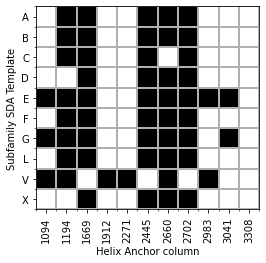

In [7]:

fig = plt.figure(figsize=[4,4], facecolor='w')
im = plt.imshow(hasAnchor.T, cmap='gray')
ax = plt.gca()
ax.set_xticks(range(len(a)))
ax.set_yticks(range(10))
ax.set_xticklabels(a, rotation=90)
ax.set_yticklabels(list("ABCDEFGLVX"))
ax.set_xticks(np.arange(-.5, 11, 1), minor=True)
ax.set_yticks(np.arange(-.5, 10, 1), minor=True)
plt.xlabel("Helix Anchor column")
plt.ylabel("Subfamily SDA Template")
ax.grid(which='minor', linewidth=2)
plt.savefig("../sda_template_anchors.png",dpi=300, bbox_inches='tight')

In [8]:
"""UNUSED CODE FROM BEFORE TEMPLATE_FINDER.py
from sklearn.cluster import MiniBatchKMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def gain_set_to_template(list_of_gains, index_list, anchors, anchor_occupation, anchor_dict, mode='template', penalty=None, n_anch=23, print_matches=False):
    distances = np.full(shape=(len(list_of_gains), n_anch), fill_value=penalty)
    all_sda_anch = []
    all_sdb_anch = []

    for gain_idx, gain in enumerate(list_of_gains):
        gain_distances, template_sda_anchors, template_sdb_anchors = match_to_template(index_list[gain_idx], 
                                                                                       gain, 
                                                                                       anchors=anchors, 
                                                                                       anchor_occupation=anchor_occupation, 
                                                                                       anchor_dict=anchor_dict,
                                                                                       n_anch=n_anch,
                                                                                       penalty=penalty, mode=mode)
        distances[gain_idx,:] = gain_distances
        all_sda_anch.append(template_sda_anchors)
        all_sdb_anch.append(template_sdb_anchors)
        if print_matches : print(template_sda_anchors, template_sdb_anchors)
    return distances, all_sda_anch, all_sdb_anch

def match_to_template(gain_idx, gain, anchors, anchor_occupation, anchor_dict, n_anch, penalty=None, mode='anchor-anchor'):
    '''
    Match a GAIN domain to a template PDB. This function has two modes. 
    In the 'template' mode, we match the closest residue to the template as the new anchor and output the residues and their distances.
    In the 'anchor-anchor' mode, we also calculate anchor-anchor distances and output them.

    gain_idx indicates the index of the domain used for locating GESAMT alignment files.
    template PDBs are global, but not needed since we are handling only the aligned files / PDBs.

    -GLOBALS
       sda_anchors, sdb_anchors, sda_a_coords, sdb_a_coords'''
    if gain.name.endswith('.'): # Adjust the name for finding the GESAMT aligned PDBs.

        name = gain.name[:-1]
    else:
        name = gain.name
    name = name.replace('(','-').replace(')','-').replace('\'','')
    
    a_gesamt_file = f'../sda_template_aligned_files/sda_{gain_idx}.out'
    b_gesamt_file = f'../sdb_template_aligned_files/sdb_{gain_idx}.out'

    #a_matches = find_anchor_matches(a_gesamt_file, sda_gain_anchors, isTarget=True)
    #b_matches = find_anchor_matches(b_gesamt_file, sdb_gain_anchors, isTarget=True)
    sda_actual_anchors = find_anchor_matches(a_gesamt_file, sda_anchors)
    sdb_actual_anchors = find_anchor_matches(b_gesamt_file, sdb_anchors)
    #print('SDA MATCHES (mobile --> template_res):', matches, '\n\nACTUAL ANCHORS (template --> mobile_res)', actual_anchors)
    #print('SDB MATCHES (mobile --> template_res):', matches, '\n\nACTUAL ANCHORS (template --> mobile_res)', actual_anchors)

    if mode == 'anchor-anchor':
        # Get the precalculated anchors from the GainDomain object, split into helices and strand dictionaries.
        _, gain_anchor_dict, _, _ = gain.create_indexing(anchors, anchor_occupation, anchor_dict,split_mode='double', silent=True)
        gain_anchors =  {k[:-3]:v+gain.start for k,v in gain_anchor_dict.items()} #modify X#.50 --> X#
        sda_gain_anchors = {k:v for k,v in gain_anchors.items() if "H" in k and v < gain.subdomain_boundary}
        sdb_gain_anchors = {k:v for k,v in gain_anchors.items() if "S" in k and v > gain.subdomain_boundary}
        # Here, the pre-defined anchor-anchor distances will be calculated.
        _, a_dist = calculate_anchor_distances(sda_a_coords, f'../sda_template_aligned_pdbs/{name}_sda.pdb', sda_gain_anchors)
        _, b_dist = calculate_anchor_distances(sdb_a_coords, f'../sdb_template_aligned_pdbs/{name}_sdb.pdb', sdb_gain_anchors)
        all_dist = {**a_dist, **b_dist}

    elif mode == 'template': 
        all_dist = {k:v[1] for k,v in {**sda_actual_anchors, **sdb_actual_anchors}.items() } #{'H1': (653, 1.04) , ...}
    # From the anchor-residue or anchor-anchor distances, construct a distance matrix where unmatched entried will be assigned a penalty value.
    else: 
        print('Unknown mode. Just returning matched anchors.')
        return None, sda_actual_anchors, sdb_actual_anchors
    # Fill a matrix with the individual distances, assign unmatched anchors a pre-set penalty value
    distances = np.full(shape=(n_anch), fill_value=penalty)
    for i, sse in enumerate(anchor_dict.values()):
        #print(i, sse)
        if sse in all_dist.keys():
            if all_dist[sse] is not None:
                distances[i] = all_dist[sse]
            #print(all_dist[sse])
            for i,val in enumerate(distances):
                if penalty is not None and val > penalty: 
                    distances[i] = penalty

    return distances, sda_actual_anchors, sdb_actual_anchors

def plot_pca(distance_matrix, cluster_intervals, n_components, name, plot3D=False, save=True):
    colorlist = ['blue','red','green','yellow','orange','purple','forestgreen','limegreen','firebrick']
    #X = anchor_distance_matrix
    X = distance_matrix
    pca = PCA(n_components=n_components)
    pca.fit(X)
    print("Explained variance ratio:", pca.explained_variance_ratio_)
    #print(pca.singular_values_)
    X_r = pca.fit(X).transform(X)
    print(X_r.shape)

    fig = plt.figure(figsize=[5,5])
    fig.set_facecolor('w')
    if plot3D:
        ax = ax = fig.add_subplot(projection='3d')
        for i, interval in enumerate(cluster_intervals):
            ax.scatter(X_r[interval[0]:interval[1],0], X_r[interval[0]:interval[1],1], X_r[interval[0]:interval[1],2], marker='o', s=8, c=colorlist[i])
    else:
        ax = fig.add_subplot()
        for i, interval in enumerate(cluster_intervals):
            ax.scatter(X_r[interval[0]:interval[1],0], X_r[interval[0]:interval[1],1], marker='o', s=8, c=colorlist[i])
    #cbar = plt.colorbar()
    #plt.figure()
    #plt.imshow(anchor_distance_matrix[::30])
    #print(np.max(anchor_distance_matrix))
    #plt.colorbar()
    ax.set_title(f'PCA of MiniBatchKMeans - {name}')
    ax.set_xlabel('PC 0')
    ax.set_ylabel('PC 1')
    if plot3D:
        ax.set_zlabel('PC 2')
    if save:
        plt.savefig(f'{name}_pca.png', dpi=300)
        
def cluster_k_means(matrix, list_of_gain_obj, n_cluster=9):
    struc_list = [gain.name for gain in list_of_gain_obj]
    clust = MiniBatchKMeans(n_clusters=n_cluster,
                            random_state=0,
                            batch_size=6,
                            max_iter=10,
                            n_init="auto").fit(matrix)
    #clust = AgglomerativeClustering(n_clusters=n_cluster, metric='euclidean', 
    #                        memory=None, connectivity=None, compute_full_tree='auto', linkage='complete', distance_threshold=None, compute_distances=True).fit(anchor_distance_matrix)
    clustering=clust.labels_
    #print(np.unique(clustering, return_counts=True))
    n_struc, n_distances = matrix.shape # 14432, 21
    #print(clustering.labels_)
    new_order = np.zeros(shape=(n_struc), dtype=int)
    current_num = 0
    for i in range(n_cluster):
        for j, cluster_id in enumerate(clustering):
            if cluster_id == i :
                new_order[j] = current_num
                current_num += 1
    #print(new_order)
    remap_dict = {old_idx:new_idx for old_idx, new_idx in enumerate(new_order)}
    inv_remap_dict = {v:k for k,v in remap_dict.items()}
    reordered_matrix = np.zeros(shape=(n_struc,n_distances))
    for x in range(n_struc):
        new_x = remap_dict[x]
        reordered_matrix[new_x,:] = matrix[x,:]

    #fig = plt.figure(figsize=[20,1])
    #fig.set_facecolor('w')
    #plt.imshow(ordered_distances.transpose(), cmap='Greys')
    #cbar = plt.colorbar()
    #cbar.set_label('RMSD [$\AA$]')
    #plt.savefig('../test_largedist.png',dpi=300)

    reordered_names = [struc_list[inv_remap_dict[k]] for k in range(n_struc)]
    reordered_clusters = [clustering[inv_remap_dict[k]] for k in range(n_struc)]

    _, cluster_starts = np.unique(reordered_clusters, return_index = True)
    cluster_intervals = [(cluster_starts[k], cluster_starts[k+1]) for k in range(n_cluster-1)]
    cluster_intervals.append((cluster_starts[-1], n_struc))
    #print(cluster_intervals)

    return reordered_matrix, cluster_intervals, reordered_names

def read_gesamt_pairs(gesamtfile):
    with open(gesamtfile) as f:
        pair_lines = [line for line in f.readlines() if line.startswith("|")][2:]
        #|H- A:LEU 720 | <**1.21**> |H- A:LEU 633 |
        #| - A:ALA 721 | <..1.54..> | + A:GLN 634 |
        #| + A:GLU 722 | <..1.75..> | + A:PRO 635 |
        #| + A:GLU 723 | <==2.03==> | + A:GLN 636 |
        #| + A:ASN 724 | <..1.91..> | - A:ALA 637 |
        #|H+ A:ARG 725 | <..2.08..> |H- A:LEU 638 |
    # construct a data structure with indices of both sides (fixed, mobile)
    mobile_pairs = {}
    template_pairs = {}
    for pair in pair_lines:
        template_str, distance_str, mobile_str = pair[9:13].strip(), pair[19:23].strip(), pair[36:40].strip()
        #print(template_str, distance_str, mobile_str, "\n", pair)
        # If either residue is empty, let the pair point to None
        if len(template_str) == 0:
            mobile_pairs[int(mobile_str)] = (None, None)
            continue
        if len(mobile_str) == 0:
            template_pairs[int(template_str)] = (None, None)
            continue
        if len(distance_str) == 0:
            dist = None
        else:
            dist = float(distance_str)
        template_pairs[int(template_str)] = (int(mobile_str), dist)
        mobile_pairs[int(mobile_str)] = (int(template_str), dist)
    
    return template_pairs, mobile_pairs

def find_anchor_matches(file, anchor_dict, isTarget=False):
    # Takes a gesamt file and an anchor dictionary either of the target or the template and returns the matched other residue with the pairwise distance
    # as a dictionary: {'H1': (653, 1.04) , ...}
    template_pairs, mobile_pairs = read_gesamt_pairs(file)
    # Find the closest residue to template anchors
    matched_residues = {}
    if not isTarget:
        parsing_dict = template_pairs
    else:
        parsing_dict = mobile_pairs

    start, end = min(parsing_dict.keys()), max(parsing_dict.keys())
    for anchor_name, anchor_res in anchor_dict.items():
        # If the anchor lies outside the aligned segments, pass empty match (None, None)
        if anchor_res < start or anchor_res > end:
            matched_residues[anchor_name] = (None, None)
            continue
        matched_residues[anchor_name] = parsing_dict[anchor_res]

    return matched_residues

def get_anchor_coords(pdbfile, anchor_dict, multistate=False):
    # Find the CA coordinates of the anchor residue in the template PDB, return dictionary with the coords for each labeled anchor
    with open(pdbfile) as p:
        if multistate:
            data = p.read().split("ENDMDL")[1]
        if not multistate:
            data = p.read()
        mdl2data = [l for l in data.split("\n") if l.startswith("ATOM")]
        ca_data = [atom for atom in mdl2data if " CA " in atom]
        #print(anchor_dict, pdbfile)
    # Find the PDB coords of the CA of each atom and get them as a dict with  {'myanchor':(x,y,z), ...}
    res_ca_dict = {int(line[22:26]):(float(line[30:38]), float(line[38:46]), float(line[46:54])) for line in ca_data}
    coord_dict={}
    for anchor_name, anchor_res in anchor_dict.items():
        if anchor_res in res_ca_dict.keys():
            coord_dict[anchor_name]=res_ca_dict[anchor_res]
        else:
            "FALLBACK. Eliminiating Residue Anchor."
            coord_dict[anchor_name]=(1000.0, 1000.0, 1000.0)
    #coord_dict = {anchor_name:res_ca_dict[anchor_res] for anchor_name, anchor_res in anchor_dict.items()}
    
    return coord_dict

def space_distance(coords1, coords2):
    # Pythagorean distance of two sets of coords
    return round(math.sqrt(abs(coords1[0]-coords2[0])**2 + abs(coords1[1]-coords2[1])**2 + abs(coords1[2]-coords2[2])**2 ),3)

def calculate_anchor_distances(template_anchor_coords, mobile_pdb, mobile_anchors, threshold=10):
    # template_anchor_coords are a precalculated set of coords to save calc time.
    # Matches always the closest Helix and sheet anchors, respectively, regardless of label.
    mobile_anchor_coords = get_anchor_coords(mobile_pdb, mobile_anchors, multistate=True)
    #distances = pd.DataFrame()
    t_anchor_names = list(template_anchor_coords.keys())
    t_coord = list(template_anchor_coords.values())
    #print(t_coord)
    anchor_occupied = np.zeros(shape=(len(template_anchor_coords.keys())), dtype=bool)
    min_dists = []
    matched_anchors = []
    double_keys = []

    mob_coords = list(mobile_anchor_coords.values())
    n_template_keys = len(list(template_anchor_coords.keys()))

    for m_coord in mob_coords:
        distances = [space_distance(m_coord, coords) for coords in t_coord]
        min_idx = np.argmin(distances)
        if anchor_occupied[min_idx] == True:
            double_keys.append(t_anchor_names[min_idx])
        anchor_occupied[min_idx] = True
        matched_anchors.append(t_anchor_names[min_idx])
        min_dists.append(distances[min_idx])

    if len(double_keys) == 0:
        return dict(zip(mobile_anchors.keys(), matched_anchors)), dict(zip(mobile_anchors.keys(), min_dists))

    # If anchors are present multiple times, delete the further distant entry and make None, None
    for doublet in double_keys:
        #print(f'{doublet = }, {matched_anchors = }, {type(matched_anchors) = }')
        indices = [i for i,x in enumerate(matched_anchors) if doublet == x]
        minimum = np.argmin(np.array(min_dists)[indices])
        indices.remove(indices[minimum])
        # Only the non-minimum values will remain in the indices list that need to be re-evaluated
        newdists = np.empty(shape=(n_template_keys))
        for idx in indices:

            for i, coord in enumerate(t_coord):
                if anchor_occupied[i] == True:
                    newdists[i] = None
                    continue
                newdists[i] = space_distance(list(mobile_anchor_coords.values())[idx], coord)
            newmindist = np.min(newdists)
            if newmindist < threshold:
                print('Found Alternative')
                anchor_occupied[np.argmin(newdists)] = True
                min_dists[idx] = newmindist
                matched_anchors[idx] = list(mobile_anchor_coords.keys())[idx]
            else: 
                #print('Removed double occurrence')
                min_dists[idx] = None
                matched_anchors[idx] = ''

    return dict(zip(mobile_anchors.keys(), matched_anchors)), dict(zip(mobile_anchors.keys(), min_dists))"""

'UNUSED CODE FROM BEFORE TEMPLATE_FINDER.py\nfrom sklearn.cluster import MiniBatchKMeans\nimport matplotlib.pyplot as plt\nfrom sklearn.decomposition import PCA\n\ndef gain_set_to_template(list_of_gains, index_list, anchors, anchor_occupation, anchor_dict, mode=\'template\', penalty=None, n_anch=23, print_matches=False):\n    distances = np.full(shape=(len(list_of_gains), n_anch), fill_value=penalty)\n    all_sda_anch = []\n    all_sdb_anch = []\n\n    for gain_idx, gain in enumerate(list_of_gains):\n        gain_distances, template_sda_anchors, template_sdb_anchors = match_to_template(index_list[gain_idx], \n                                                                                       gain, \n                                                                                       anchors=anchors, \n                                                                                       anchor_occupation=anchor_occupation, \n                                                        

In [9]:
def get_family(name):
    queries = [('AGR..', name, lambda x: x[-1][-2:]), #
                ('ADGR..', name, lambda x: x[-1][-2:]), 
                ('cadher.*receptor.', name.lower(), lambda x: f"C{x[-1][-1]}"),
                ('cels?r.', name.lower(), lambda x: f"C{x[-1][-1]}"), 
                ('latrophilin.*protein-?\d', name.lower(), lambda x: f"L{x[-1][-1]}"),
                ('latrophilin-?\d', name.lower(), lambda x: f"L{x[-1][-1]}"),
                ('GP?R133', name.upper(),lambda x: 'D1'),
                ('GP?R126', name.upper(),lambda x: 'G6'),
                ('GP?R?124', name.upper(),lambda x: 'A2'),
                ('GP?R?125', name.upper(),lambda x: 'A3'),
                ('GP?R112', name.upper(),lambda x: 'G4'),
                ('GP?R116', name.upper(),lambda x: 'F5'),
                ('GP?R144', name.upper(),lambda x: 'D2'),
                ('ag-?.*-?coupled-?receptor-?.-?\d', name.lower(),lambda x: x[-1].replace('-','')[-2:].upper()),
                ('brain-?specific-?angiogenesis-?inhibitor-?\d', name.lower(), lambda x: f"B{x[-1][-1]}"),
                ('emr\d', name.lower(), lambda x: f"E{x[-1][-1]}"),
                ]
    for pattern, searchstring, output in queries:
        match = re.findall(pattern, searchstring)
        if match != []:
            #if output(match) == '': print(name)
            return output(match)
    return 'X'

fam_list = [get_family(gain.name) for gain in valid_collection.collection]
name_list = [gain.name for gain in valid_collection.collection]
subfam_list = [x[0] for x in fam_list]
receptors, counts  = np.unique(fam_list, return_counts=True)
r_list = list(zip(receptors,counts))
print(r_list)
print(receptors)
fam_counts = {}
for prot in fam_list:
    fam = prot[0]
    if fam not in fam_counts.keys():
        fam_counts[fam] = 0
    fam_counts[fam] += 1

print(fam_counts)

[('A1', 84), ('A2', 442), ('A3', 700), ('B1', 383), ('B2', 701), ('B3', 372), ('C1', 287), ('C2', 233), ('C3', 308), ('D1', 580), ('D2', 428), ('E1', 260), ('E2', 188), ('E3', 180), ('E4', 78), ('E5', 155), ('E7', 1), ('E8', 2), ('E9', 1), ('F1', 179), ('F2', 113), ('F3', 187), ('F4', 147), ('F5', 664), ('F6', 2), ('F7', 9), ('F8', 1), ('G1', 544), ('G2', 570), ('G3', 127), ('G4', 151), ('G5', 175), ('G6', 853), ('G7', 147), ('L1', 690), ('L2', 1646), ('L3', 1220), ('L4', 564), ('V1', 144), ('X', 916)]
['A1' 'A2' 'A3' 'B1' 'B2' 'B3' 'C1' 'C2' 'C3' 'D1' 'D2' 'E1' 'E2' 'E3'
 'E4' 'E5' 'E7' 'E8' 'E9' 'F1' 'F2' 'F3' 'F4' 'F5' 'F6' 'F7' 'F8' 'G1'
 'G2' 'G3' 'G4' 'G5' 'G6' 'G7' 'L1' 'L2' 'L3' 'L4' 'V1' 'X']
{'C': 828, 'X': 916, 'G': 2567, 'F': 1302, 'D': 1008, 'A': 1226, 'L': 4120, 'B': 1456, 'E': 865, 'V': 144}


In [12]:
# match everything for each subfamily.
#print(subfam_list)

y = len(r_list)
# famstring
template_ids = list(templates.keys())

t_occupancies = {}
t_distances = {}

for t_id in template_ids:
    t_anchors = template_anchors[t_id]
    t_quality = template_quality[t_id]
    t_folder = templates[t_id][-1]
    n_anch = len(t_anchors.keys())
    print(t_anchors)
    anchor_index = {k:i for i, k in enumerate(t_anchors.keys())}
    assigned_anchor_freq = np.zeros(shape=(len(receptors),n_anch))
    all_anchor_averages = np.full(shape=(y,n_anch), fill_value=None)
    all_anchor_occupancy = np.zeros(shape=(y,n_anch))

    for fam_idx, r in enumerate(receptors):# in enumerate('ABCDEFGLVX'):
        gain_subset = [ gain for i, gain in enumerate(valid_collection.collection) if fam_list[i] == r]#subfam_list[i]==r ]
        gain_idx_list = [ i for i,gain in enumerate(fam_list) if gain == r ]
        #print(r, len(gain_subset))

        element_occupation = {k:0 for k in t_anchors.keys()}

        for key, val in element_occupation.items():
            assigned_anchor_freq[fam_idx, anchor_index[key]] = float(val)/len(gain_subset)

        fam_distances, fam_matched_anchors = tf.gain_set_to_template(gain_subset, gain_idx_list, t_anchors, t_folder, penalty=None, debug=False)
        #print(fam_distances, fam_matched_anchors)
        #schwabbel
        mean_dist = np.empty(shape=(n_anch))
        occ = np.zeros(shape=(n_anch))
        
        for j in range(n_anch):
            occ_values = np.array([d for d in fam_distances[:,j] if d is not None])
            if len(occ_values) != 0:
                mean_dist[j] = round(np.mean(occ_values), 3)
                occ[j] = round(np.count_nonzero(fam_distances[:,j])/len(gain_idx_list), 3)
        all_anchor_averages[fam_idx,:] = mean_dist #np.mean(fam_distances, axis=0)
        all_anchor_occupancy[fam_idx,:] = occ
        #print(all_anchor_averages)
        #print(all_anchor_occupancy)
    print(f"Done with Template {t_id}.\n", "_"*30)

    t_distances[t_id] = all_anchor_averages
    t_occupancies[t_id] = all_anchor_occupancy

        #reordered_t_distances, t_cluster_intervals, reordered_t_names = cluster_k_means(fam_distances, gain_subset, 9)
        #plot_pca(reordered_t_distances, t_cluster_intervals, n_components=2, plot3D=False, name=f'PCA_ADGR{fam_string}')

{'S1': 324, 'S2': 335, 'S3': 353, 'S4': 359, 'S5': 381, 'S6': 409, 'S7': 414, 'S8': 436, 'S9': 453, 'S10': 470, 'S11': 478, 'S12': 487}
Done with Template sdb.
 ______________________________
{'H1': 424, 'H2': 439, 'H3': 454, 'H4': 489, 'H5': 497, 'H6': 514}
Done with Template A.
 ______________________________
{'H1': 541, 'H2': 556, 'H3': 569, 'H4': 607, 'H5': 615, 'H6': 633}
Done with Template B.
 ______________________________
{'H1': 463, 'H2': 484, 'H3': 498, 'H4': 524, 'H5': 541, 'H6': 549, 'H7': 567}
Done with Template C.
 ______________________________
{'H1': 376, 'H2': 385, 'H3': 417, 'H4': 435, 'H5': 480, 'H6': 488, 'H7': 506}
Done with Template D.
 ______________________________
{'H1': 255, 'H2': 276, 'H3': 309}
Done with Template E.
 ______________________________
{'H1': 531, 'H2': 550, 'H3': 567, 'H4': 601, 'H5': 609, 'H6': 628}
Done with Template F.
 ______________________________
{'H1': 543, 'H2': 557, 'H3': 590, 'H4': 609}
Done with Template G.
 _________________________

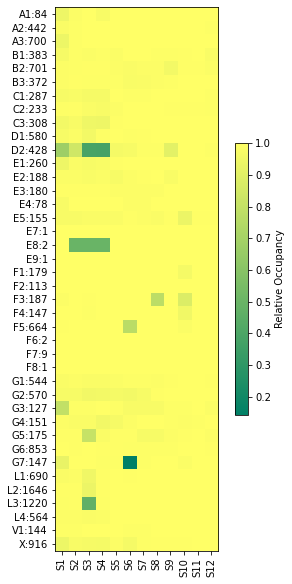

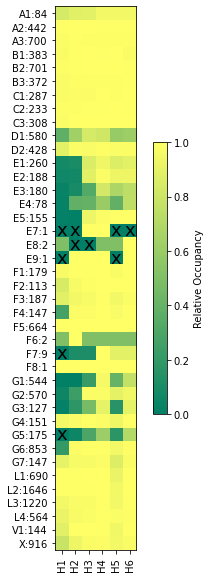

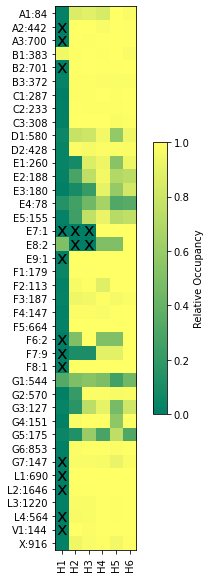

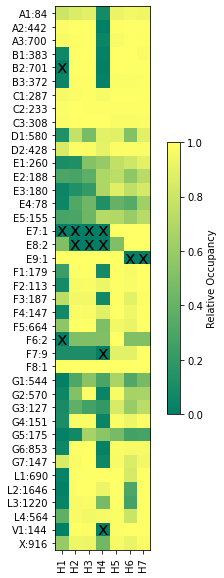

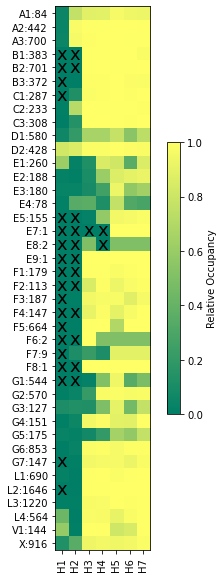

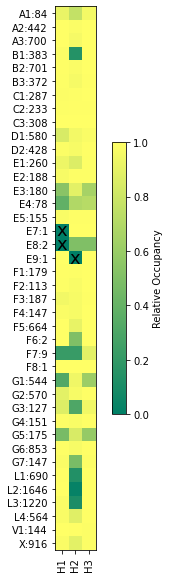

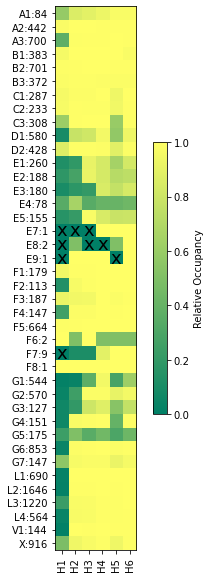

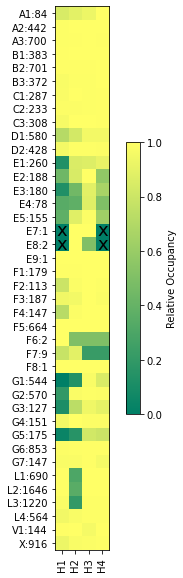

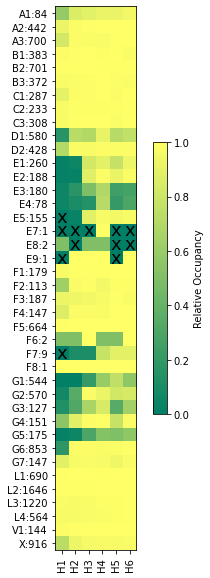

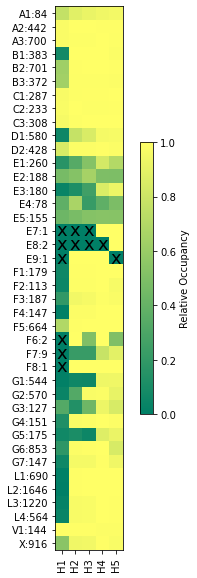

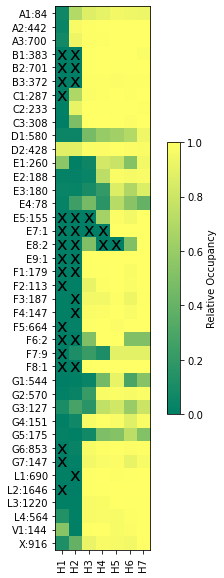

In [14]:
# Plot the fit.
for t_id in template_ids:
    t_anchors = template_anchors[t_id]
    n_anch = len(t_anchors.keys())
    t_anchor_freqs = t_occupancies[t_id]

    fig = plt.figure(figsize=[6,10], facecolor='w')
    #plt.yticks(ticks = range(ydim), labels= [f'ADGR{f}' for f in 'ABCDEFGLVX'])
    plt.title(f"Template Match for : {t_id}")
    plt.yticks(ticks = range(len(r_list)), labels= [f'{i[0]}:{i[1]}' for i in r_list])
    plt.xticks(ticks = range(n_anch), labels=t_anchors.keys(), rotation=90)
    plt.imshow(t_anchor_freqs, cmap='summer')
    cbar = plt.colorbar(shrink=0.5)
    cbar.set_label('Relative Occupancy')
    ydim = len(r_list)
    for y in range(ydim):
        for x in range(n_anch):
            if t_anchor_freqs[y,x] > 0.001:
                pass
            else:
                plt.text(x,y,'x', horizontalalignment='center', verticalalignment='center', fontsize=18,color='k')
    plt.savefig(f'{t_id}_occupancy.png', dpi=300)

In [ ]:
print(all_anchor_averages.shape)
#allsse =[f'H{a}' for a in range(1,9)]+[f'S{a}' for a in range(1,14)]
allsse =[f'H{a}' for a in range(1,8)]+[f'S{a}' for a in range(1,20)]
df = pd.DataFrame(data=all_anchor_averages, index = r_list, columns=allsse)
print(df)
docc = pd.DataFrame(data=all_anchor_occupancy, index = r_list, columns=allsse)
print(docc)
element_occupation = {k:0 for k in allsse}
n_hels = {np.zeros(shape=14432)}
n_sheets = np.zeros(shape=14432)
for i, gain in enumerate(valid_collection.collection):
    _, cd, _, _ = gain.create_indexing(anchors, anchor_occupation, anchor_dict,split_mode='double', silent=True)
    h,s = 0,0
    for k in cd.keys():
        element_occupation[k[:-3]] += 1 
        if k.startswith('H'): h += 1
        elif k.startswith('S'): s +=1
    n_hels[i] = h
    n_sheets[i] = s

In [ ]:
print(element_occupation)
print(np.unique(n_hels, return_counts=True))
print(np.unique(n_sheets, return_counts=True))
print(anchors, anchor_dict)

In [ ]:
import matplotlib.patches as patches
ydim = 40
fig = plt.figure(figsize=[8,ydim/3], facecolor='w')
plt.imshow(docc, cmap='spring')
#plt.yticks(ticks = range(ydim), labels= [f'ADGR{f}' for f in 'ABCDEFGLVX'])
plt.yticks(ticks = range(ydim), labels= [f'{i[0]}:{i[1]}' for i in r_list])
plt.xticks(ticks = range(n_anch), labels= allsse, rotation=90)

all_anchor_averages # 10,21
for y in range(ydim):
    for x in range(n_anch):
        if all_anchor_averages[y,x] > 0.0001:
            plt.text(x,y, round(all_anchor_averages[y,x], 2), horizontalalignment='center', verticalalignment='center', fontsize=7,color='k', rotation=45)
cbar = plt.colorbar(shrink=float(8/ydim))
cbar.set_label('Relative Occupancy')
plt.vlines(6.5,-0.5,ydim-0.5, color='k', linewidth=1.5)
plt.savefig('identity_receptor_anchor_occupancy.png', dpi=300)

In [ ]:

fig = plt.figure(figsize=[8,ydim/3], facecolor='w')
#plt.imshow(df, cmap='summer')
im_data = np.zeros(shape=(ydim, n_anch))

print(all_anchor_averages.shape)
#plt.yticks(ticks = range(10), labels= [f'ADGR{f}' for f in 'ABCDEFGLVX'])
plt.yticks(ticks = range(ydim), labels= [f'{i[0]}:{i[1]}' for i in r_list])
plt.xticks(ticks = range(n_anch), labels= allsse, rotation=90)
#all_anchor_averages # 10,21
for y in range(ydim):
    for x in range(n_anch):
        if all_anchor_averages[y,x] > 0.001:
            im_data[y,x] = all_anchor_averages[y,x]
        else:
            plt.text(x,y,'x', horizontalalignment='center', verticalalignment='center', fontsize=20,color='k')
            #patches.Rectangle((x,y), 1, 1, linewidth=0.5, edgecolor='k', facecolor='w')
plt.imshow(im_data, cmap='summer', vmax=3)
            #plt.text(x,y, round(all_anchor_averages[y,x], 2), horizontalalignment='center', verticalalignment='center', fontsize=7,color='k', rotation=45)
cbar = plt.colorbar(shrink=float(8)/ydim)
cbar.set_label(r'Closest Anchor Residue Distance [$\AA$]')
plt.vlines(6.5,-0.5,ydim-0.5, color='k', linewidth=1.5)
plt.savefig('identity_receptor_anchor_distance.png', dpi=300)

In [ ]:
import matplotlib.patches as patches
ydim = 40
fig = plt.figure(figsize=[8,ydim/3], facecolor='w')

#plt.yticks(ticks = range(ydim), labels= [f'ADGR{f}' for f in 'ABCDEFGLVX'])
plt.yticks(ticks = range(ydim), labels= [f'{i[0]}:{i[1]}' for i in r_list])
plt.xticks(ticks = range(n_anch), labels= allsse, rotation=90)
occ_values = df.to_numpy()
is_off = np.zeros(shape=(40,26))
print(docc.shape, all_anchor_averages.shape)
#all_anchor_averages # 10,21
for y in range(ydim):
    for x in range(n_anch):
        if all_anchor_averages[y,x] is not None and all_anchor_averages[y,x] > 1.5 and occ_values[y,x] > 0.1:
            is_off[y,x] = 1
            plt.text(x,y, round(all_anchor_averages[y,x], 2), horizontalalignment='center', verticalalignment='center', fontsize=7,color='k', rotation=45)
plt.imshow(is_off, cmap='spring')
cbar = plt.colorbar(shrink=float(8/ydim))
cbar.set_label('Relative Occupancy')
plt.vlines(6.5,-0.5,ydim-0.5, color='k', linewidth=1.5)
#plt.savefig('identity_receptor_anchor_occupancy.png', dpi=300)

In [ ]:
sse_stats = np.zeros(shape = (n_anch, 2))

for fam_idx, r in enumerate(receptors):# in enumerate('ABCDEFGLVX'):
    print(r)
    gain_subset = [ gain for i, gain in enumerate(valid_collection.collection) if fam_list[i] == r]#subfam_list[i]==r ]
    gain_idx_list = [ i for i,gain in enumerate(fam_list) if gain == r ]
    n_sse = [[len(gain.sda_helices), len(gain.sdb_sheets)] for gain in gain_subset] # (n_struc, 2)
    n_strucs = np.mean(np.array(n_sse), axis=0)
    print(r, round(n_strucs[0], 2), round(n_strucs[1],2))


In [ ]:
# new Anchor management.
#
# Use the "max" SDA / SDB template for generating the new anchors 
# For each of the SSE 
#   get the center residue index
#   For each GAIN
#       Find closest residue to the center, note down the sequence, start, end of the matched SSE
#   Run MAFFT with each of the gathered sequences
#   For each MAFFT
#       Find the most conserved residue (Identity matrix)
#       Set as new Anchor.

In [ ]:
# new Anchor management.

#
# Use the "max" SDA / SDB template for generating the new anchors 
# get the center residue index for each template SSE
for gain in valid_collection.collection:
    if gain.name[:10] == 'A0A7K7IHI9': #SDA
        hel_centers = []
        for hel in gain.sda_helices: # each hel is a tuple
            hel_centers.append( gain.start + int((hel[0]+hel[1])/2) )
        hel_keys = [f'H{i+1}' for i in range(len(hel_centers))]
        sda_centers = dict(zip(hel_keys, hel_centers))
    if gain.name[:10] =='A0A3P9I6M5':
        sheet_centers = []
        for sheet in gain.sdb_sheets: # each hel is a tuple
            #if sheet[1] - sheet[0] < 3:
            #    print(gain.start+sheet[0], gain.start+sheet[1])
            sheet_centers.append( gain.start + int((sheet[0]+sheet[1])/2) )
        sheet_keys = [f'S{i+1}' for i in range(len(sheet_centers))]
        sdb_centers = dict(zip(sheet_keys, sheet_centers))
# Manually curated the centers to exclude two small strands in the CD between S6/S7 @ 707-708 and 711-713, respectively (low pLDDT here).
sda_centers = {'H1': 313, 'H2': 328, 'H3': 359, 'H4': 383, 'H5': 409, 'H6': 424, 'H7': 444}
sdb_centers = {'S1': 622, 'S2': 631, 'S3': 645, 'S4': 658, 'S5': 670, 'S6': 695, 'S7': 719, 'S8': 736, 'S9': 752, 'S10': 765, 'S11': 771, 'S12': 782, 'S13': 793}

# Find closest residue to the center (GESAMT), note down the sequence, start, end of the matched SSE; write to FASTA
    # A dict of dicts --> for each key, there is a dictionary inside sse_seqs['H1'][gain.name]:'seqlist'
all_keys = list({**sda_centers, **sdb_centers}.keys())
sse_seqs = {k:{} for k in all_keys}
sse_extents = {k:{} for k in all_keys}
unmatched = {k:0 for k in all_keys}
unstructured = {k:0 for k in all_keys}

for i, gain in enumerate(valid_collection.collection):
        a_gesamt_file = f'../sda_template_aligned_files/sda_{i}.out'
        b_gesamt_file = f'../sdb_template_aligned_files/sdb_{i}.out'

        sda_matches = find_anchor_matches(a_gesamt_file, sda_centers, isTarget=False)
        sdb_matches = find_anchor_matches(b_gesamt_file, sdb_centers, isTarget=False)
        #print(sda_matches, sdb_matches)
        hel_extents = np.full(shape = (gain.end-gain.start+1), fill_value=100)
        she_extents = np.full(shape = (gain.end-gain.start+1), fill_value=100)
        # Establish two matrices to match the respective residue to the index of its helix/sheet for easier matching
        for i,element in enumerate(gain.sda_helices):
            hel_extents[element[0]:element[1]] = i
        for i,element in enumerate(gain.sdb_sheets):
            she_extents[element[0]:element[1]] = i
        # Match the corresponding closest residue to find the associated SSE with start, end and sequence
        for sse, match in sda_matches.items():
            if match[0] is None:
                unmatched[sse] += 1
                continue

            sse_index = hel_extents[match[0]-gain.start]

            if sse_index == 100:
                unstructured[sse] += 1
                continue

            sse_extents[sse][gain.name] = gain.sda_helices[sse_index]
            sse_seqs[sse][gain.name] = gain.sequence[gain.sda_helices[sse_index][0]:gain.sda_helices[sse_index][1]]
        
        for sse, match in sdb_matches.items():
            if match[0] is None:
                unmatched[sse] += 1
                continue

            sse_index = she_extents[match[0]-gain.start]

            if sse_index == 100:
                unstructured[sse] += 1
                continue

            sse_extents[sse][gain.name] = gain.sdb_sheets[sse_index]
            sse_seqs[sse][gain.name] = gain.sequence[gain.sdb_sheets[sse_index][0]:gain.sdb_sheets[sse_index][1]]
        
for sse in all_keys:
    with open(f'../sse_aln/{sse}.seqs.fa','w') as fa:
        for name, seq in sse_seqs[sse].items():
            fa.write(f'>{name}\n{"".join(seq)}\n')

print(unmatched, '\n', unstructured)
#   Run MAFFT with each of the gathered sequences
#   For each MAFFT
#       Find the most conserved residue (Identity matrix)
#       Set as new Anchor.

In [ ]:

for gain in valid_collection.collection:

    if gain.name[:10] == 'A0A7K7IHI9': #SDA
        sda_gain = gain
    if gain.name[:10] =='A0A3P9I6M5': # SDB
        sdb_gain = gain
for i,k in enumerate(sda_centers.keys()):
    kfile = glob.glob(f"../sse_aln/{k}.aln.fa")[0]
    with open(kfile) as alnf:
        x = alnf.readlines()[1].strip(" \n")
        kcutoff = len(x)
    print(kcutoff)
    aln = sse_func.read_alignment(kfile, cutoff=kcutoff)
    h = sda_gain.sda_helices[i]
    aln_matrix = np.array([list(seq) for seq in aln.values()])
    kquality, kocc = calc_identity(aln_matrix)
    '''    kquality = []
    kocc = []
    for col in range(aln_matrix.shape[1]):
        chars, count = np.unique(aln_matrix[:,col], return_counts=True)
        if chars[0] == '-':
            q = count[1]
        else:
            q = count[0]
        x = np.where(chars == '-')[0][0]
        kocc.append(14435 - count[x])
        kquality.append(q)'''
    template_aln_seq = aln[sda_gain.name]
    template_res_idx = np.argmax(kquality)
    print(template_aln_seq, template_res_idx)
    template_index = template_aln_seq[:template_res_idx+1]
    t_res = template_aln_seq[template_res_idx]
    print(template_index, t_res)
    new = template_index

    fig = plt.figure(figsize=[4,2], facecolor='w')
    plt.bar(range(kcutoff), kquality)
    plt.title(f'SDA TEMPLATE : {k}')
    plt.xticks(ticks = range(kcutoff), labels=template_aln_seq, fontsize=5)
    plt.savefig(f'../sse_aln/{k}.template1.png', dpi=300)
    plt.close(fig)

for i,k in enumerate(sdb_centers.keys()):
    kfile = glob.glob(f"../sse_aln/{k}.aln.fa")[0]
    with open(kfile) as alnf:
        x = alnf.readlines()[1].strip(" \n")
        kcutoff = len(x)
    print(kcutoff)
    aln = sse_func.read_alignment(kfile, cutoff=kcutoff)
    h = sdb_gain.sdb_sheets[i]
    aln_matrix = np.array([list(seq) for seq in aln.values()])
    kquality = []
    kocc = []
    kquality, kocc = calc_identity(aln_matrix)
        
    template_aln_seq = aln[sdb_gain.name]
    template_res_idx = np.argmax(kquality)
    print(template_aln_seq, template_res_idx)
    template_index = template_aln_seq[:template_res_idx+1]
    t_res = template_aln_seq[template_res_idx]
    print(template_index, t_res)
    new = template_index

    fig = plt.figure(figsize=[4,2], facecolor='w')
    plt.bar(range(kcutoff), kquality)
    plt.title(f'SDB TEMPLATE : {k}')
    plt.xticks(ticks = range(kcutoff), labels=template_aln_seq, fontsize=5)
    plt.savefig(f'../sse_aln/{k}.template1.png', dpi=300)
    plt.close(fig)